### Get uncorrected bigwigs

In [1]:
import pyBigWig
import pandas as pd
import numpy as np

uncorrected_bigwig = "/srv/scratch/anusri/chrombpnet_paper/GM12878/data/shifted_4_4.sorted.bam.bpnet.unstranded.bw"

uncorretced_bw = pyBigWig.open(uncorrected_bigwig)

spi1_bed = "/srv/scratch/anusri/chrombpnet_paper/GM12878/tf_bed/SPI1_task0_peaks.bed"
spi1_peaks = pd.read_csv(spi1_bed, delimiter="\t").sample(frac=0.001)
print(spi1_peaks.shape)
print(spi1_peaks.head())



(44, 10)
       chr12  102483806  102484090  .  1000 ..1   4.13574  -1.00000  0.54391  \
18289  chr10   83373722   83374006  .  1000   .  34.99925      -1.0  4.71746   
18778   chr5   80240355   80240639  .  1000   .  35.79656      -1.0  4.71746   
34281   chr1  119069818  119069982  .  1000   .  95.83233      -1.0  4.71746   
18234   chr1  248688753  248689037  .  1000   .  34.90617      -1.0  4.71746   
31189   chr1  200363206  200363490  .  1000   .  74.16524      -1.0  4.71746   

       142  
18289  142  
18778  142  
34281   84  
18234  142  
31189  142  


In [2]:
def fetch_footprint_from_bigwig(bed_file,bw):
    foot_prints = []
    for i in range(bed_file.shape[0]):
        start = int(bed_file.iloc[i,1])
        summit = int(bed_file.iloc[i,-1])
        flank=150
        foot_prints.append(bw.values(bed_file.iloc[i,0], start+summit-flank, start+summit+flank))
    
    foot_prints = np.array(foot_prints)
    return np.mean(foot_prints, axis=0)
    
    
    

In [3]:
uncorrected_footprints = fetch_footprint_from_bigwig(spi1_peaks,uncorretced_bw)

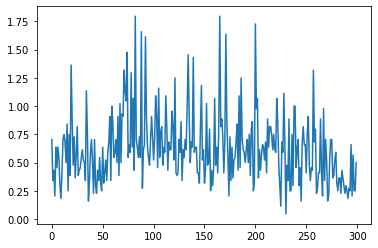

In [4]:
import matplotlib.pyplot as plt
plt.plot(uncorrected_footprints)




In [5]:
from load_model import *
import os
import pyfaidx

os.environ["CUDA_VISIBLE_DEVICES"]="3"
corrected_model=load_model_wrapper(model_hdf5="/srv/scratch/anusri/chrombpnet_paper/GM12878/ATAC_07.22.2021/final_model_step3/unplug/model.0.hdf5")
reference_genome_path="/mnt/data/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta"
reader = pyfaidx.Fasta(reference_genome_path)

Instructions for updating:
non-resource variables are not supported in the long term


Using TensorFlow backend.


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence (InputLayer)           [(None, 2114, 4)]    0                                            
__________________________________________________________________________________________________
1st_conv (Conv1D)               (None, 2094, 500)    42500       sequence[0][0]                   
__________________________________________________________________________________________________
0_non_dil-crop_1th_dconv (Cropp (None, 2090, 500)    0           1st_conv[0][0]                   
__________________________________________________________________________________________________
1_dilconv (Conv1D)              (None, 2090, 500)    750500      1st_conv[0][0]                   
_______________________________________________________________________________________

In [6]:
def fetch_footprint_from_model(bed_file,model):
    foot_prints = []
    for i in range(bed_file.shape[0]):
        start = int(bed_file.iloc[i,1])
        summit = int(bed_file.iloc[i,-1])
        flank=1057
        flank_tf=150
        seq = reader[bed_file.iloc[i,0]][start+summit-flank:start+summit+flank].seq
        one_hot_seq = np.identity(4)[np.unique(list(seq), return_inverse=True)[1]]
        input_tensor = tf.convert_to_tensor(one_hot_seq[None])
        predictions = model(input_tensor)[0]
        predictions = predictions.eval(session=get_session())
        foot_prints.append(predictions[0][500-flank_tf:500+flank_tf,0])
        #plt.plot(predictions.reshape(-1))
        
    foot_prints = np.array(foot_prints)
    return np.mean(foot_prints, axis=0)


[<matplotlib.lines.Line2D at 0x7fa97b029910>]

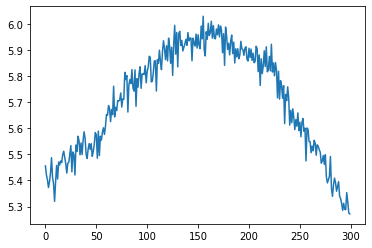

In [7]:
corrected_footprints = fetch_footprint_from_model(spi1_peaks,corrected_model)
import matplotlib.pyplot as plt
plt.plot(corrected_footprints)





In [ ]:
def get_seq(genome, peaks_df, width=2000):
    vals = []
    for i, r in peaks_df.iterrows():
        vals.append(str(reader[r['chr']][(r['start']+r['summit'] - width//2):(r['start'] + r['summit'] + width//2)]))
        
    return one_hot.dna_to_one_hot(vals)